# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

titanic_train_link = 'https://drive.google.com/open?id=1Ss4nKvq-nFedjc7FV-KvCrPXyZ1Qzjop'
fluff, titanic_train_id = titanic_train_link.split('=')
downloaded_titanic_train = drive.CreateFile({'id':titanic_train_id}) 
downloaded_titanic_train.GetContentFile('titanic_train.csv')
df_titanic_train = pd.read_csv('titanic_train.csv')


train_Y = df_titanic_train['Survived']
df = df_titanic_train.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [4]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.275783
Ticket      0.161384
Name        0.138862
Fare        0.121432
Age         0.107011
Cabin       0.070998
Pclass      0.049237
SibSp       0.034633
Embarked    0.020496
Parch       0.020165
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

>> | 反而留前7比前5好

In [5]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8260980705280222

In [16]:
# 高重要性特徵 + 隨機森林
high_feature = list(feats[:7].index) #反而7比5好
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8272028348240488

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

>> | yap


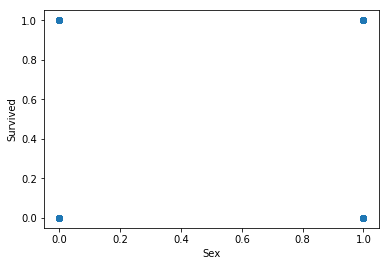

In [21]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(y=train_Y, x=df['Sex'], fit_reg=False)
plt.show()

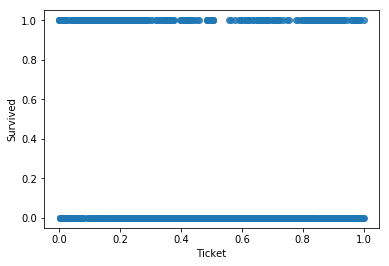

In [22]:
# 第二名       
sns.regplot(y=train_Y, x=df['Ticket'], fit_reg=False)
plt.show()

In [23]:
# 製作新特徵看效果
df['Add_char'] = (df['Sex'] + df['Ticket']) / 2
df['Multi_char'] = (df['Sex'] * df['Ticket'])
df['ST_divd'] = df['Sex'] / (df['Ticket'] + 1) * 2
df['TS_divd'] = df['Ticket'] / (df['Sex'] + 1) * 2

train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8283327783268735